# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice, i.e. a total of 5 models are to be trained.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [110]:
# pip install pandas
# pip install scikit-learn
# pip install wordcloud
import pandas as pd
import sklearn as sk

# load the data
responsesFromBothDRTV2 = pd.read_excel('alldata.xlsx')
responsesFromBothDRTV2.rename(columns={'alder': 'Age', 'storkreds': 'District', 'navn': 'Name', 'parti': 'Party'}, inplace=True)
responsesFromDR=pd.read_excel('drdata.xlsx')
responsesFromDR.rename(columns={'navn': 'Name', 'parti': 'Party' }, inplace=True)
questionsFromDR=pd.read_excel('drq.xlsx')
questionsFromDR.rename(columns={'ID': 'id', }, inplace=True)
questionsFromTV2=pd.read_excel('tv2q.xlsx')
questionsFromTV2.rename(columns={'question': 'Question', 'header': 'Title'}, inplace=True)
responsesFromTV2=pd.read_excel('tv2data.xlsx')
responsesFromTV2.rename(columns={'navn': 'Name', 'parti': 'Party', 'alder': 'Age', 'storkreds': 'District'}, inplace=True)
electedData=pd.read_excel('electeddata.xlsx')
electedData.rename(columns={'navn': 'Name', 'parti': 'Party', 'alder': 'Age', 'storkreds': 'District'}, inplace=True)

# Define DR and TV2 question columns based on the given IDs
dr_questions = ['530', '531', '533', '534', '535', '537', '538', '540', '541', '543', '544', 
                '545', '546', '547', '548', '550', '551', '552', '553', '555', '556', '557', 
                '559', '561', '563']  # DR question columns
tv2_questions = ['1a', '1b', '2a', '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', 
                 '7a', '7b', '8a', '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b']

#Creating DR dataframe with questions+Responses
"""Note: Missing ages and districts for candidates
Only place to look for arguments for and against"""
responses_melted = responsesFromDR.melt(
    id_vars=['Name', 'Party'],  # Use Name and Party (adjust if needed)
    value_vars=dr_questions,  # Use only existing question ID columns
    var_name='id',
    value_name='response'
)
responses_melted['id'] = responses_melted['id'].astype(int)

merged_DRdata = pd.merge(
    responses_melted, 
    questionsFromDR, 
    left_on='id',  # Column in the melted DataFrame
    right_on='id',  # Column in the questions DataFrame
    how='left'  # Use a left join to keep all responses
)
# Remove the 'Wordmerge'(only contains 1 value:(0) and 'Info'(only contains 1 value: NAn) columns & 'Rule'(only contains 1 value: 'FT')
#'ID_CandidateQuestionType (only contained 1 value) & QuestionListData (only contains Nan)
merged_DRdata.drop(columns=['WordMerger','Info','ID_CandidateQuestionType', 'QuestionListData'], inplace=True, errors='ignore')
print(merged_DRdata.head())
print(merged_DRdata.columns.tolist())

#Creating TV2 Dataframe
"""Note: Best place to look at age and district as these columns do not exist in the response from DR
Removal of type column and depends column is recommend as 'type' only contains one value: 'rate' as we only have 
data from ratings in this dataframe. 
Depends column allows candidate to select an area where they want their answer to apply(not relevant for many of the 
questions so NaN is a popular response). This column only contains Nan when merged with responses so it should be dropped as it 
is only relevant for questions we do not have data on 
"""
responses_meltedTV2 = responsesFromTV2.melt(
    id_vars=['Name', 'Party', 'Age', 'District'], 
    value_vars=tv2_questions,  
    var_name='id',
    value_name='response'
)
responses_meltedTV2['id'] = responses_meltedTV2['id'].astype(str)
questionsFromTV2['id'] = questionsFromTV2['id'].astype(str)

merged_TV2data = pd.merge(responses_meltedTV2, questionsFromTV2, left_on='id', right_on='id', how='left')

# Remove the 'depends' and 'type' columns 
merged_TV2data.drop(columns=['depends', 'type'], inplace=True, errors='ignore')

print(merged_TV2data.head())
print(merged_TV2data.columns.tolist())


# Dataframe for elected data
"""Results from the candidates that were elected - 169 Cnadidates included (9 missing)
Elected responses contains names, ages, parties and districts"""
responses_melted_DR_Elected = electedData.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  # Keep these columns unchanged
    value_vars=dr_questions,  # Use only DR question columns
    var_name='id',  # Create an 'id' column for the question ID
    value_name='response'  # Store the response value in the 'response' column
)
responses_melted_DR_Elected['id'] = responses_melted_DR_Elected['id'].astype(str)
responses_melted_TV2_Elected = electedData.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  
    value_vars=tv2_questions,  
    var_name='id',  
    value_name='response'  
)
responses_melted_TV2_Elected['id'] = responses_melted_TV2_Elected['id'].astype(str)

combined_elected_responses = pd.concat([responses_melted_DR_Elected, responses_melted_TV2_Elected], ignore_index=True)
# Ensure the 'ID' in DR and 'id' in TV2 question metadata are the same type (string)
questionsFromDR['id'] = questionsFromDR['id'].astype(str)
questionsFromTV2['id'] = questionsFromTV2['id'].astype(str)


# Step 4: Concatenate DR and TV2 question metadata
combined_questions = pd.concat([questionsFromDR[['id', 'Question']], questionsFromTV2[['id', 'Question']]], ignore_index=True)

# Merge the concatenated questions with the combined responses
combined_elected_responses = pd.merge(
    combined_elected_responses, 
    combined_questions,  # Concatenated question text from both DR and TV2
    on='id',  # Merge on the 'id' column (now shared by both DR and TV2)
    how='left'  # Left join to keep all responses
)

print(combined_elected_responses.head())
print(combined_elected_responses.columns.tolist())

#Creating Combined Responses - the bothDRTV2 dataframe with questions and responses
"""Things to note:
There are more question ID's than there are response IDs so not all questions we have answers to . The questions we do not have responses to are automatically filtered out of this dataframe
There is no age or district column in the responses from DR´so it may make sense to drop those columns when looking at combined data Find it below"""
responses_melted = responsesFromBothDRTV2.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  # Keep candidate information
    value_vars=dr_questions + tv2_questions,  # Use both DR and TV2 question IDs
    var_name='id',  # Create a single 'id' column for both DR and TV2 question IDs
    value_name='response'  # Store responses in 'response' column
)


final_combined_all_candidate_data = pd.merge(
    responses_melted, 
    combined_questions,  # Combine the question text
    on='id',  # Merge on 'id' to match questions with responses
    how='left'  # Use left join to retain all responses
)

# Remove the 'Age' and 'District' columns because they are only in the TV2 dataframe
final_combined_all_candidate_data.drop(columns=['Age', 'District'], inplace=True, errors='ignore')

# Step 5: View the final combined data
print(final_combined_all_candidate_data.head())
print(final_combined_all_candidate_data.columns.tolist())

print(responsesFromTV2.columns.tolist())
print(responsesFromDR.columns.tolist())






                 





                       Name                    Party   id  response  \
0      Lars Philipsen Prahm              Moderaterne  530        -1   
1             Karsten Hønge  Socialistisk Folkeparti  530         2   
2  Martin Kelleher-Petersen             Alternativet  530         2   
3    Nicklas Gjedsig Larsen             Alternativet  530         2   
4            Tom Gillesberg                Løsgænger  530         1   

             Title                                           Question  \
0  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   
1  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   
2  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   
3  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   
4  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   

                                         ArgumentFor  \
0  Den kollektive trafik bør være billig og tilgæ...   
1  Den kollektive traf

In [270]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load and process data
responsesFromBothDRTV2_LR = pd.read_excel('alldata.xlsx')
responsesFromBothDRTV2_LR.rename(columns={'alder': 'Age', 'storkreds': 'District', 'navn': 'Name', 'parti': 'Party'}, inplace=True)
questionsFromDR_LR = pd.read_excel('drq.xlsx')
questionsFromDR_LR.rename(columns={'ID': 'id', }, inplace=True)
questionsFromTV2_LR = pd.read_excel('tv2q.xlsx')
questionsFromTV2_LR.rename(columns={'question': 'Question', 'header': 'Title'}, inplace=True)

# Define DR and TV2 question columns based on the given IDs
dr_questions_LR = ['530', '531', '533', '534', '535', '537', '538', '540', '541', '543', '544', 
                '545', '546', '547', '548', '550', '551', '552', '553', '555', '556', '557', 
                '559', '561', '563']  # DR question columns
tv2_questions_LR = ['1a', '1b', '2a', '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', 
                 '7a', '7b', '8a', '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b']

#Creating DR dataframe with questions+Responses
"""Note: Missing ages and districts for candidates
Only place to look for arguments for and against"""



# Melt the data
responses_melted_LR = responsesFromBothDRTV2_LR.melt(
    id_vars=['Name', 'Party'],  # Keep candidate information
    value_vars=dr_questions_LR + tv2_questions_LR,  # Use both DR and TV2 question IDs
    var_name='id',  # Create a single 'id' column for both DR and TV2 question IDs
    value_name='response'  # Store responses in 'response' column
)



# Merge the responses with the question metadata
final_combined_all_candidate_data_LR = pd.merge(
    responses_melted_LR, 
    combined_questions,  # Combine the question text
    on='id',  # Merge on 'id' to match questions with responses
    how='left'  # Use left join to retain all responses
)

# Ensure the 'ID' in DR and 'id' in TV2 question metadata are the same type (string)
questionsFromDR_LR['id'] = questionsFromDR_LR['id'].astype(str)
questionsFromTV2_LR['id'] = questionsFromTV2_LR['id'].astype(str)

# Step 4: Concatenate DR and TV2 question metadata
combined_questions_LR = pd.concat([questionsFromDR_LR[['id', 'Question','Title']], questionsFromTV2_LR[['id', 'Question','Title']]], ignore_index=True)

# Remove the 'Age' and 'District' columns because they are only in the TV2 dataframe
final_combined_all_candidate_data_LR.drop(columns=['Age', 'District'], inplace=True, errors='ignore')

print(final_combined_all_candidate_data_LR.columns)

# Create the mapping for parties to political positions
party_to_position_LR = {
    'Moderaterne': 'Centre-left',
    'Socialistisk Folkeparti': 'Left-wing',
    'Alternativet': 'Centre-left',
    'Enhedslisten': 'Far-left',
    'Danmarksdemokraterne': 'Right-wing',
    'Venstre': 'Centre-right',
    'Frie Grønne, Danmarks Nye Venstrefløjsparti': 'Centre-left',
    'Dansk Folkeparti': 'Far-right',
    'Kristendemokraterne': 'Centre-right',
    'Liberal Alliance': 'Right-wing',
    'Nye Borgerlige': 'Far-right',
    'Det Konservative Folkeparti': 'Right-wing',
    'Radikale Venstre': 'Centre-left',
    'Socialdemokratiet': 'Centre-left'
}

# Step 4: Concatenate DR and TV2 question metadata
combined_questions_LR = pd.concat(
    [questionsFromDR_LR[['id', 'Question', 'Title']],
     questionsFromTV2_LR[['id', 'Question', 'Title']]],
    ignore_index=True
)

# Check if the Title column is present in combined_questions_LR
print(combined_questions_LR.columns)  # Ensure 'Title' is present

# Ensure response ids are of type string
responses_melted_LR['id'] = responses_melted_LR['id'].astype(str)
combined_questions_LR['id'] = combined_questions_LR['id'].astype(str)

# Merge the responses with the combined questions metadata
final_combined_all_candidate_data_LR = pd.merge(
    responses_melted_LR,
    combined_questions_LR,  # Ensure combined_questions_LR contains the 'Title'
    on='id',
    how='left'  # Use left join to retain all responses
)

# Check if 'Title' column is present in final_combined_all_candidate_data_LR
print(final_combined_all_candidate_data_LR.columns)
print(final_combined_all_candidate_data_LR['Title'].isnull().sum())  # Check for missing titles

# Filter out rows with missing Title if necessary
filtered_data_LR = final_combined_all_candidate_data_LR[final_combined_all_candidate_data_LR['Title'].notnull()]

# Map political position
filtered_data_LR['Political Position'] = filtered_data_LR['Party'].map(party_to_position_LR)

# Create a new dataframe with Party, Question, Response, Political Position, and Title
political_Position_df_LR = filtered_data_LR[['Party', 'Title', 'Question', 'response', 'Political Position']]



# Filter out 'Løsgænger' rows
filtered_data_LR = final_combined_all_candidate_data_LR[final_combined_all_candidate_data_LR['Party'] != 'Løsgænger']

# Map the political position to a new column based on the party
filtered_data_LR['Political Position'] = filtered_data_LR['Party'].map(party_to_position_LR)

# Create a new dataframe with only Party, Question, Response, and Political Position columns
political_Position_df_LR = filtered_data_LR[['Party', 'Title','Question', 'response', 'Political Position']]

# Step 1: Create the binary outcome for strong opinions (either -2 or 2)
political_Position_df_LR['strong_opinion'] = np.where(political_Position_df_LR['response'].isin([-2, 2]), 1, 0)

# Step 2: Create a binary predictor for far-left political position
political_Position_df_LR['is_far_left'] = np.where(political_Position_df_LR['Political Position'] == 'Far-left', 1, 0)

# Step 3: Prepare the final dataset with relevant columns
# Include more features like 'Party' and 'Title'
data_for_model_LR = political_Position_df_LR[['is_far_left', 'strong_opinion', 'Party', 'Title']]

# Step 4: Create a binary target variable for strong opinions
# 1 if strong opinion (either -2 or 2), 0 otherwise
y_LR = data_for_model_LR['strong_opinion']

# Step 5: Prepare features
# One-Hot Encode categorical features 'Party' and 'Title'
X_LR = data_for_model_LR[['is_far_left', 'Party', 'Title']]

# Step 6: Preprocessing with OneHotEncoder
# Create a pipeline to handle encoding and model fitting
preprocessor_LR = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Party', 'Title']),
        ('num', 'passthrough', ['is_far_left'])  # Keep the binary feature as is
    ]
)

# Step 7: Split the data into training and testing sets
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X_LR, y_LR, test_size=0.3, random_state=42)

# Step 8: Initialize and fit the logistic regression model
model_LR = Pipeline(steps=[('preprocessor', preprocessor_LR),
                         ('logistic', LogisticRegression())])

model_LR.fit(X_train_LR, y_train_LR)

# Step 9: Make predictions on the test set
y_pred_LR = model_LR.predict(X_test_LR)

# Step 10: Evaluate the model's performance
accuracy_LR = accuracy_score(y_test_LR, y_pred_LR)
print(f'Accuracy: {accuracy_LR:.2f}')
print(classification_report(y_test_LR, y_pred_LR))


Index(['Name', 'Party', 'id', 'response', 'Question'], dtype='object')
Index(['id', 'Question', 'Title'], dtype='object')
Index(['Name', 'Party', 'id', 'response', 'Question', 'Title'], dtype='object')
0
Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.67      0.74      0.70      6872
           1       0.65      0.56      0.60      5829

    accuracy                           0.66     12701
   macro avg       0.66      0.65      0.65     12701
weighted avg       0.66      0.66      0.66     12701



C:\Users\camil\AppData\Local\Temp\ipykernel_32524\134150150.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_LR['Political Position'] = filtered_data_LR['Party'].map(party_to_position_LR)
C:\Users\camil\AppData\Local\Temp\ipykernel_32524\134150150.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_Position_df_LR['strong_opinion'] = np.where(political_Position_df_LR['response'].isin([-2, 2]), 1, 0)


In [271]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Load and process data
responsesFromBothDRTV2_NB = pd.read_excel('alldata.xlsx')
responsesFromBothDRTV2_NB.rename(columns={'alder': 'Age', 'storkreds': 'District', 'navn': 'Name', 'parti': 'Party'}, inplace=True)
questionsFromDR_NB = pd.read_excel('drq.xlsx')
questionsFromDR_NB.rename(columns={'ID': 'id'}, inplace=True)
questionsFromTV2_NB = pd.read_excel('tv2q.xlsx')
questionsFromTV2_NB.rename(columns={'question': 'Question', 'header': 'Title'}, inplace=True)

# Melt the data
responses_melted_NB = responsesFromBothDRTV2_NB.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  # Keep candidate information
    value_vars=dr_questions + tv2_questions,  # Use both DR and TV2 question IDs
    var_name='id',  # Create a single 'id' column for both DR and TV2 question IDs
    value_name='response'  # Store responses in 'response' column
)

# Merge the responses with the question metadata
final_combined_all_candidate_data_NB = pd.merge(
    responses_melted_NB, 
    combined_questions,  # Combine the question text
    on='id',  # Merge on 'id' to match questions with responses
    how='left'  # Use left join to retain all responses
)

# Create the mapping for parties to political positions
party_to_position_NB = {
    'Moderaterne': 'Centre-left',
    'Socialistisk Folkeparti': 'Left-wing',
    'Alternativet': 'Centre-left',
    'Enhedslisten': 'Far-left',
    'Danmarksdemokraterne': 'Right-wing',
    'Venstre': 'Centre-right',
    'Frie Grønne, Danmarks Nye Venstrefløjsparti': 'Centre-left',
    'Dansk Folkeparti': 'Far-right',
    'Kristendemokraterne': 'Centre-right',
    'Liberal Alliance': 'Right-wing',
    'Nye Borgerlige': 'Far-right',
    'Det Konservative Folkeparti': 'Right-wing',
    'Radikale Venstre': 'Centre-left',
    'Socialdemokratiet': 'Centre-left'
}
# Step 4: Concatenate DR and TV2 question metadata
combined_questions_NB = pd.concat(
    [questionsFromDR_NB[['id', 'Question', 'Title']],
     questionsFromTV2_NB[['id', 'Question', 'Title']]],
    ignore_index=True
)

# Check if the Title column is present in combined_questions_LR
print(combined_questions_NB.columns)  # Ensure 'Title' is present

# Ensure response ids are of type string
responses_melted_NB['id'] = responses_melted_NB['id'].astype(str)
combined_questions_NB['id'] = combined_questions_NB['id'].astype(str)

# Merge the responses with the combined questions metadata
final_combined_all_candidate_data_NB = pd.merge(
    responses_melted_NB,
    combined_questions_NB,  # Ensure combined_questions_LR contains the 'Title'
    on='id',
    how='left'  # Use left join to retain all responses
)

# Check if 'Title' column is present in final_combined_all_candidate_data_LR
print(final_combined_all_candidate_data_NB.columns)
print(final_combined_all_candidate_data_NB['Title'].isnull().sum())  # Check for missing titles

# Filter out rows with missing Title if necessary
filtered_data_NB = final_combined_all_candidate_data_NB[final_combined_all_candidate_data_NB['Title'].notnull()]

# Map political position
filtered_data_NB['Political Position'] = filtered_data_NB['Party'].map(party_to_position_LR)

# Create a new dataframe with Party, Question, Response, Political Position, and Title
political_Position_df_NB = filtered_data_NB[['Party', 'Title', 'Question', 'response', 'Political Position']]



# Filter out 'Løsgænger' rows
filtered_data_NB = final_combined_all_candidate_data_NB[final_combined_all_candidate_data_NB['Party'] != 'Løsgænger']

# Map the political position to a new column based on the party
filtered_data_NB['Political Position'] = filtered_data_NB['Party'].map(party_to_position_NB)

# Create a new dataframe with only Party, Question, Response, and Political Position columns
political_Position_df_NB = filtered_data_NB[['Party', 'Title', 'response', 'Political Position','Question']]

# Step 1: Create the binary outcome for strong opinions (either -2 or 2)
political_Position_df_NB['strong_opinion'] = np.where(political_Position_df_NB['response'].isin([-2, 2]), 1, 0)

# Step 2: Create binary predictors for centre-left, centre-right, and other political positions
political_Position_df_NB['is_centre_left'] = np.where(political_Position_df_NB['Political Position'].isin(['Centre-left', 'Left-wing']), 1, 0)
political_Position_df_NB['is_centre_right'] = np.where(political_Position_df_NB['Political Position'].isin(['Centre-right', 'Right-wing']), 1, 0)

# Binary flag for those who are neither centre-left nor centre-right
political_Position_df_NB['is_not_centre_left_or_centre_right'] = np.where(
    (political_Position_df_NB['Political Position'] != 'Centre-left') & 
    (political_Position_df_NB['Political Position'] != 'Centre-right'), 1, 0
)

# Step 3: Prepare the final dataset with relevant columns
# Include binary features for centre-left, centre-right, and others
data_for_model_NB = political_Position_df_NB[['strong_opinion', 'is_centre_left', 'is_centre_right', 'is_not_centre_left_or_centre_right', 'Party', 'Title','Question']]

# Step 4: Create a binary target variable for strong opinions
# 1 if strong opinion (either -2 or 2), 0 otherwise
y_NB = data_for_model_NB['strong_opinion']

# Step 5: Prepare features (X)
X_NB = data_for_model_NB[['is_centre_left', 'is_centre_right', 'is_not_centre_left_or_centre_right', 'Party', 'Title','Question']]

# Step 6: Preprocessing (One-Hot Encode 'Party' and 'Title')
preprocessor_NB = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Party', 'Title','Question']),  
        ('num', 'passthrough', ['is_centre_left', 'is_centre_right', 'is_not_centre_left_or_centre_right'])  # Numerical columns
    ]
)

# Step 7: Split the data into training and testing sets
X_train_NB, X_test_NB, y_train_NB, y_test_NB = train_test_split(X_NB, y_NB, test_size=0.3, random_state=42)

# Step 8: Initialize and fit the Naive Bayes model (MultinomialNB)
model_NB = Pipeline(steps=[('preprocessor', preprocessor_NB),
                           ('naive_bayes', MultinomialNB())])

model_NB.fit(X_train_NB, y_train_NB)

# Step 9: Make predictions on the test set
y_pred_NB = model_NB.predict(X_test_NB)

# Step 10: Evaluate the model's performance
accuracy_NB = accuracy_score(y_test_NB, y_pred_NB)
print(f'Accuracy: {accuracy_NB:.2f}')
print(classification_report(y_test_NB, y_pred_NB))



Index(['id', 'Question', 'Title'], dtype='object')
Index(['Name', 'Party', 'Age', 'District', 'id', 'response', 'Question',
       'Title'],
      dtype='object')
0
Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      6872
           1       0.66      0.61      0.63      5829

    accuracy                           0.68     12701
   macro avg       0.67      0.67      0.67     12701
weighted avg       0.68      0.68      0.68     12701



C:\Users\camil\AppData\Local\Temp\ipykernel_32524\670335862.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_NB['Political Position'] = filtered_data_NB['Party'].map(party_to_position_NB)
C:\Users\camil\AppData\Local\Temp\ipykernel_32524\670335862.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_Position_df_NB['strong_opinion'] = np.where(political_Position_df_NB['response'].isin([-2, 2]), 1, 0)
C:\Users\camil\AppData\Local\Temp\ipykernel_32524\670335862.py:102: SettingWithCo

C:\Users\camil\AppData\Local\Temp\ipykernel_32524\1015252016.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_Position_df_BoxPlot['Political Position'] = pd.Categorical(
C:\Users\camil\AppData\Local\Temp\ipykernel_32524\1015252016.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


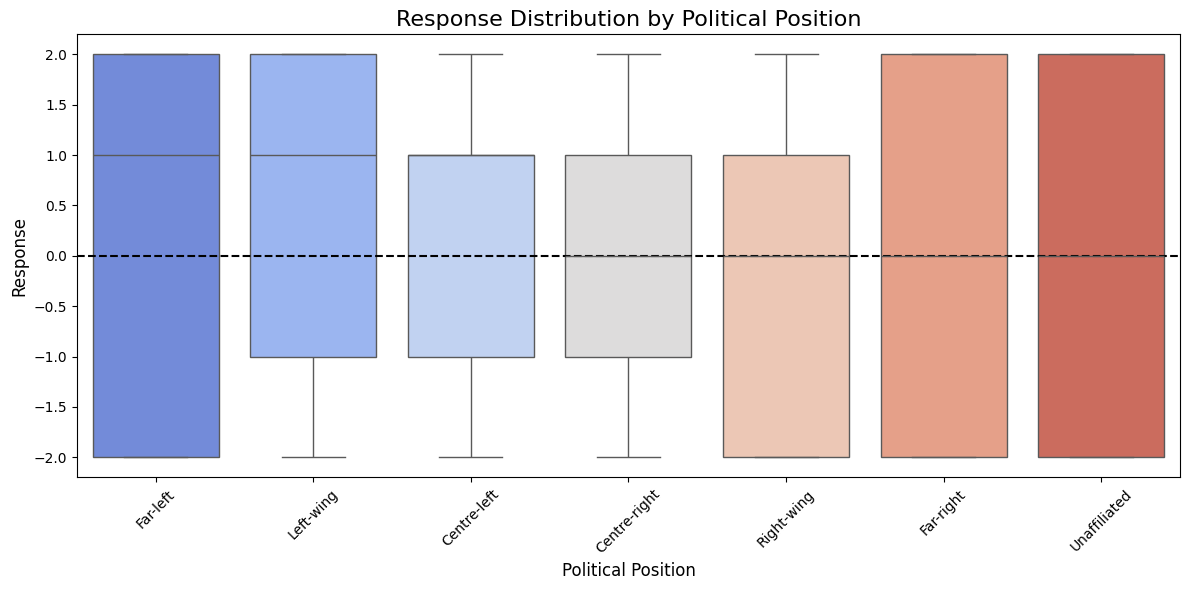

In [219]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and process data
responsesFromBothDRTV2_BoxPlot = pd.read_excel('alldata.xlsx')
responsesFromBothDRTV2_BoxPlot.rename(columns={'alder': 'Age', 'storkreds': 'District', 'navn': 'Name', 'parti': 'Party'}, inplace=True)
questionsFromDR_BoxPlot = pd.read_excel('drq.xlsx')
questionsFromDR_BoxPlot.rename(columns={'ID': 'id', }, inplace=True)
questionsFromTV2_BoxPlot = pd.read_excel('tv2q.xlsx')
questionsFromTV2_BoxPlot.rename(columns={'question': 'Question', 'header': 'Title'}, inplace=True)

# Melt the data
responses_melted_BoxPlot = responsesFromBothDRTV2_BoxPlot.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  # Keep candidate information
    value_vars=dr_questions + tv2_questions,  # Use both DR and TV2 question IDs
    var_name='id',  # Create a single 'id' column for both DR and TV2 question IDs
    value_name='response'  # Store responses in 'response' column
)

# Merge the responses with the question metadata
final_combined_all_candidate_data_BoxPlot = pd.merge(
    responses_melted_BoxPlot, 
    combined_questions,  # Combine the question text
    on='id',  # Merge on 'id' to match questions with responses
    how='left'  # Use left join to retain all responses
)

# Ensure 'id' in DR and TV2 question metadata are the same type (string)
questionsFromDR_BoxPlot['id'] = questionsFromDR_BoxPlot['id'].astype(str)
questionsFromTV2_BoxPlot['id'] = questionsFromTV2_BoxPlot['id'].astype(str)

# Concatenate DR and TV2 question metadata
combined_questions_BoxPlot = pd.concat([questionsFromDR_BoxPlot[['id', 'Question', 'Title']], questionsFromTV2_BoxPlot[['id', 'Question', 'Title']]], ignore_index=True)

# Remove the 'Age' and 'District' columns because they are only in the TV2 dataframe
final_combined_all_candidate_data_BoxPlot.drop(columns=['Age', 'District'], inplace=True, errors='ignore')

# Map parties to political positions
party_to_position_BoxPlot = {
    'Moderaterne': 'Centre-left',
    'Socialistisk Folkeparti': 'Left-wing',
    'Alternativet': 'Centre-left',
    'Enhedslisten': 'Far-left',
    'Danmarksdemokraterne': 'Right-wing',
    'Venstre': 'Centre-right',
    'Frie Grønne, Danmarks Nye Venstrefløjsparti': 'Centre-left',
    'Dansk Folkeparti': 'Far-right',
    'Kristendemokraterne': 'Centre-right',
    'Liberal Alliance': 'Right-wing',
    'Nye Borgerlige': 'Far-right',
    'Det Konservative Folkeparti': 'Right-wing',
    'Radikale Venstre': 'Centre-left',
    'Socialdemokratiet': 'Centre-left',
    'Løsgænger': 'Unaffiliated'
}

# Map political positions to a new column based on the party
final_combined_all_candidate_data_BoxPlot['Political Position'] = final_combined_all_candidate_data_BoxPlot['Party'].map(party_to_position_BoxPlot)

# Create a new dataframe with selected columns
political_Position_df_BoxPlot = final_combined_all_candidate_data_BoxPlot[['Party', 'Title', 'Question', 'response', 'Political Position']]

# Step 6: Define the desired order for the political spectrum
position_order_BoxPlot = ['Far-left', 'Left-wing', 'Centre-left', 'Centre-right', 'Right-wing', 'Far-right', 'Unaffiliated']

# Convert 'Political Position' to a categorical type with the defined order
political_Position_df_BoxPlot['Political Position'] = pd.Categorical(
    political_Position_df_BoxPlot['Political Position'],
    categories=position_order_BoxPlot,
    ordered=True
)

# Create a boxplot for response distribution by political position
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Political Position',
    y='response',
    data=political_Position_df_BoxPlot,
    palette='coolwarm'
)

plt.title('Response Distribution by Political Position', fontsize=16)
plt.xlabel('Political Position', fontsize=12)
plt.ylabel('Response', fontsize=12)
plt.axhline(0, color='black', linestyle='--')  # Add a horizontal line at 0 for reference
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [265]:
# Line Chart Tracking Average Responses by Political Position

responsesFromBothDRTV2_LineChart = pd.read_excel('alldata.xlsx')
responsesFromBothDRTV2_LineChart.rename(columns={'alder': 'Age', 'storkreds': 'District', 'navn': 'Name', 'parti': 'Party'}, inplace=True)
questionsFromDR_LineChart = pd.read_excel('drq.xlsx')
questionsFromDR_LineChart.rename(columns={'ID': 'id'}, inplace=True)
questionsFromTV2_LineChart = pd.read_excel('tv2q.xlsx')
questionsFromTV2_LineChart.rename(columns={'question': 'Question', 'header': 'Title'}, inplace=True)

responses_melted_LineChart = responsesFromBothDRTV2_LineChart.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  # Keep candidate information
    value_vars=dr_questions + tv2_questions,  # Use both DR and TV2 question IDs
    var_name='id',  # Create a single 'id' column for both DR and TV2 question IDs
    value_name='response'  # Store responses in 'response' column
)

final_combined_all_candidate_data_LineChart = pd.merge(
    responses_melted_LineChart, 
    combined_questions,  # Combine the question text
    on='id',  # Merge on 'id' to match questions with responses
    how='left'  # Use left join to retain all responses
)

# Ensure the 'ID' in DR and 'id' in TV2 question metadata are the same type (string)
questionsFromDR_LineChart['id'] = questionsFromDR_LineChart['id'].astype(str)
questionsFromTV2_LineChart['id'] = questionsFromTV2_LineChart['id'].astype(str)

# Step 4: Concatenate DR and TV2 question metadata
combined_questions_LineChart = pd.concat([questionsFromDR_LineChart[['id', 'Question', 'Title']], 
                                          questionsFromTV2_LineChart[['id', 'Question', 'Title']]], 
                                         ignore_index=True)

# Remove the 'Age' and 'District' columns because they are only in the TV2 dataframe
final_combined_all_candidate_data_LineChart.drop(columns=['Age', 'District'], inplace=True, errors='ignore')

# Create the mapping for parties to political positions
party_to_position_LineChart = {
    'Moderaterne': 'Centre-left',
    'Socialistisk Folkeparti': 'Left-wing',
    'Alternativet': 'Centre-left',
    'Enhedslisten': 'Far-left',
    'Danmarksdemokraterne': 'Right-wing',
    'Venstre': 'Centre-right',
    'Frie Grønne, Danmarks Nye Venstrefløjsparti': 'Centre-left',
    'Dansk Folkeparti': 'Far-right',
    'Kristendemokraterne': 'Centre-right',
    'Liberal Alliance': 'Right-wing',
    'Nye Borgerlige': 'Far-right',
    'Det Konservative Folkeparti': 'Right-wing',
    'Radikale Venstre': 'Centre-left',
    'Socialdemokratiet': 'Centre-left'
}

# Filter out 'Løsgænger' rows - Not relevant when looking at political affiliations here
filtered_data_LineChart = final_combined_all_candidate_data_LineChart[final_combined_all_candidate_data_LineChart['Party'] != 'Løsgænger']
filtered_data_LineChart['Political Position'] = filtered_data_LineChart['Party'].map(party_to_position_LineChart)

political_Position_df_LineChart = filtered_data_LineChart[['Party', 'Title', 'Question', 'response', 'Political Position']]

# Step 6: Define the desired order for the political spectrum
position_order_LineChart= ['Far-left', 'Left-wing', 'Centre-left', 'Centre-right', 'Right-wing', 'Far-right']

# Convert the 'Political Position' column to a categorical type with the specific order
political_Position_df_LineChart['Political Position'] = pd.Categorical(
    political_Position_df_LineChart['Political Position'], 
    categories=position_order_LineChart, 
    ordered=True
)

# Calculate average responses by political position (you likely have a similar step elsewhere)
average_responses_by_position = political_Position_df_LineChart.groupby('Political Position')['response'].mean()


plt.figure(figsize=(10, 6))
sns.pointplot(
    x='Political Position',
    y='response',
    data=average_responses_by_position.reset_index(),
    capsize=0.1,
    color='blue'
)

plt.title('Average Responses Ordered By Political Position', fontsize=16)
plt.xlabel('Political Position', fontsize=12)
plt.ylabel('Average Response', fontsize=12)
plt.axhline(0, color='black', linestyle='--')  # Add a horizontal line at 0 for reference

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


C:\Users\camil\AppData\Local\Temp\ipykernel_32524\1160915889.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_LineChart['Political Position'] = filtered_data_LineChart['Party'].map(party_to_position_LineChart)


KeyError: "['Title'] not in index"

C:\Users\camil\AppData\Local\Temp\ipykernel_32524\4061301767.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_BarChart['Political Position'] = filtered_data_BarChart['Party'].map(party_to_position_BarChart)
C:\Users\camil\AppData\Local\Temp\ipykernel_32524\4061301767.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_Position_df_BarChart['Political Position'] = pd.Categorical(


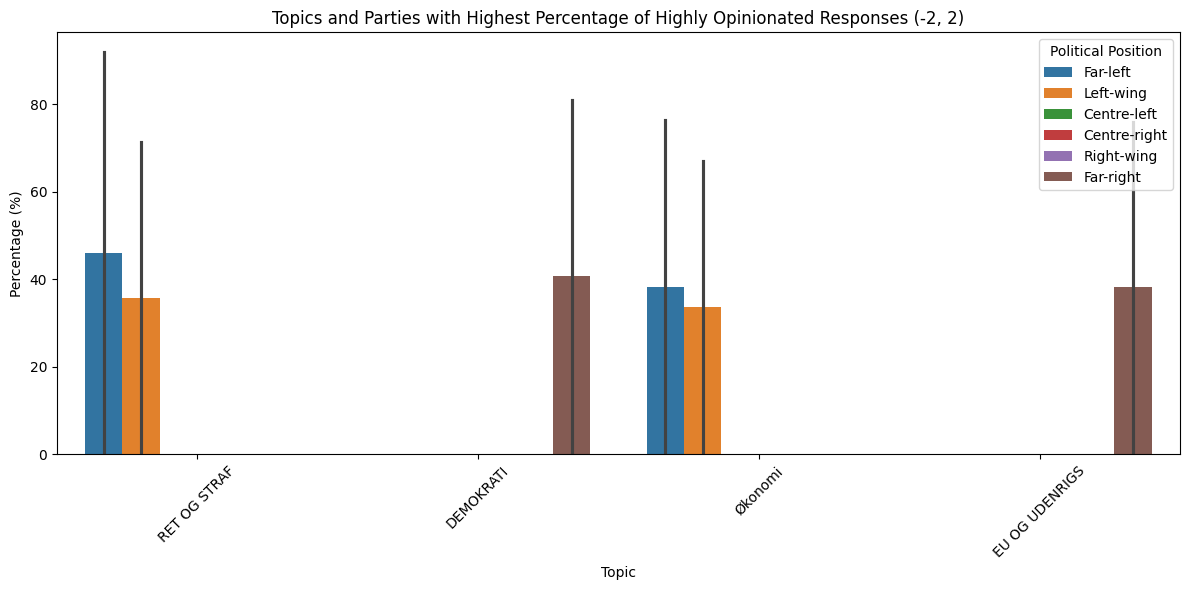

In [240]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load and process data
responsesFromBothDRTV2_BarChart = pd.read_excel('alldata.xlsx')
responsesFromBothDRTV2_BarChart.rename(columns={'alder': 'Age', 'storkreds': 'District', 'navn': 'Name', 'parti': 'Party'}, inplace=True)
questionsFromDR_BarChart = pd.read_excel('drq.xlsx')
questionsFromDR_BarChart.rename(columns={'ID': 'id'}, inplace=True)
questionsFromTV2_BarChart = pd.read_excel('tv2q.xlsx')
questionsFromTV2_BarChart.rename(columns={'question': 'Question', 'header': 'Title'}, inplace=True)

# Melt the responses
responses_melted_BarChart = responsesFromBothDRTV2_BarChart.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  # Keep candidate information
    value_vars=dr_questions + tv2_questions,  # Use both DR and TV2 question IDs
    var_name='id',  # Create a single 'id' column for both DR and TV2 question IDs
    value_name='response'  # Store responses in 'response' column
)

# Combine the question text with the responses
final_combined_all_candidate_data_BarChart = pd.merge(
    responses_melted_BarChart, 
    combined_questions,  # Combine the question text
    on='id',  # Merge on 'id' to match questions with responses
    how='left'  # Use left join to retain all responses
)

# Ensure the 'ID' in DR and 'id' in TV2 question metadata are the same type (string)
questionsFromDR_BarChart['id'] = questionsFromDR_BarChart['id'].astype(str)
questionsFromTV2_BarChart['id'] = questionsFromTV2_BarChart['id'].astype(str)

# Step 4: Concatenate DR and TV2 question metadata
combined_questions_BarChart = pd.concat([questionsFromDR_BarChart[['id', 'Question', 'Title']], 
                                          questionsFromTV2_BarChart[['id', 'Question', 'Title']]], 
                                         ignore_index=True)

# Remove the 'Age' and 'District' columns because they are only in the TV2 dataframe
final_combined_all_candidate_data_BarChart.drop(columns=['Age', 'District'], inplace=True, errors='ignore')

# Create the mapping for parties to political positions
party_to_position_BarChart = {
    'Moderaterne': 'Centre-left',
    'Socialistisk Folkeparti': 'Left-wing',
    'Alternativet': 'Centre-left',
    'Enhedslisten': 'Far-left',
    'Danmarksdemokraterne': 'Right-wing',
    'Venstre': 'Centre-right',
    'Frie Grønne, Danmarks Nye Venstrefløjsparti': 'Centre-left',
    'Dansk Folkeparti': 'Far-right',
    'Kristendemokraterne': 'Centre-right',
    'Liberal Alliance': 'Right-wing',
    'Nye Borgerlige': 'Far-right',
    'Det Konservative Folkeparti': 'Right-wing',
    'Radikale Venstre': 'Centre-left',
    'Socialdemokratiet': 'Centre-left'
}

# Filter out 'Løsgænger' rows
filtered_data_BarChart = final_combined_all_candidate_data_BarChart[final_combined_all_candidate_data_BarChart['Party'] != 'Løsgænger']
filtered_data_BarChart['Political Position'] = filtered_data_BarChart['Party'].map(party_to_position_BarChart)

# Create the political position DataFrame
political_Position_df_BarChart = filtered_data_BarChart[['Party', 'Title', 'Question', 'response', 'Political Position']]

# Step 6: Define the desired order for the political spectrum
position_order_BarChart = ['Far-left', 'Left-wing', 'Centre-left', 'Centre-right', 'Right-wing', 'Far-right']

# Convert the 'Political Position' column to a categorical type with the specific order
political_Position_df_BarChart['Political Position'] = pd.Categorical(
    political_Position_df_BarChart['Political Position'], 
    categories=position_order_BarChart, 
    ordered=True
)

# Step 1: Filter for responses that are either 2 or -2
filtered_responses_barChart = political_Position_df_BarChart[political_Position_df_BarChart['response'].isin([2, -2])]

# Step 2: Group by political position, title, and response, then count occurrences
count_responses_barChart = filtered_responses_barChart.groupby(['Political Position', 'Title', 'response']).size().reset_index(name='Count')

# Step 3: Calculate total responses (including all response values, not just 2 and -2)
total_responses_barChart = political_Position_df_BarChart.groupby(['Political Position', 'Title']).size().reset_index(name='Total_Responses')

# Step 4: Merge total responses with the filtered count_responses DataFrame
merged_df_barChart = count_responses_barChart.merge(total_responses_barChart, on=['Political Position', 'Title'])

# Step 5: Calculate the percentage for responses of 2 and -2
merged_df_barChart['Percentage'] = (merged_df_barChart['Count'] / merged_df_barChart['Total_Responses']) * 100

# Step 6: Pivot the table so that you have separate columns for the % of 2 and % of -2
final_df_barChart = merged_df_barChart.pivot_table(index=['Political Position', 'Title'], 
                                 columns='response', 
                                 values='Percentage').reset_index()

# Step 7: Rename columns for better readability
final_df_barChart.columns = ['Political Position', 'Title', '(%) of -2', '(%) of 2']

# Step 8: Sort the final DataFrame by '% of -2' in descending order
final_df_sorted_barChart = final_df_barChart.sort_values(by='(%) of -2', ascending=False)

# Step 9: Get the top 3 for % of -2
top_3_negative_barChart = final_df_sorted_barChart.nlargest(3, '(%) of -2')

# Step 10: Get the top 3 for % of 2
top_3_positive_barChart = final_df_sorted_barChart.nlargest(3, '(%) of 2')

# Step 11: Combine the top 3 DataFrames
top_titles_barChart = pd.concat([top_3_negative_barChart, top_3_positive_barChart]).drop_duplicates()

# Step 12: Melt the DataFrame to have a long format for seaborn, including Political Position
melted_df_barChart = top_titles_barChart.melt(id_vars=['Political Position', 'Title'], 
                              value_vars=['(%) of 2', '(%) of -2'], 
                              var_name='Response Type', 
                              value_name='Percentage')

# Step 13: Create the plot
plt.figure(figsize=(12, 6))

# Change hue to 'Political Position' for better distinction
sns.barplot(data=melted_df_barChart, x='Title', y='Percentage', hue='Political Position', dodge=True)

# Step 14: Add labels and title
plt.title('Topics and Parties with Highest Percentage of Highly Opinionated Responses (-2, 2)')
plt.xlabel('Topic')
plt.ylabel('Percentage (%)')
plt.legend(title='Political Position')  # Change legend title to Political Position
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

# Step 15: Replace NaN values with 0 in '% of -2' and '% of 2' columns
top_titles_barChart['(%) of -2'] = top_titles_barChart['(%) of -2'].fillna(0)
top_titles_barChart['(%) of 2'] = top_titles_barChart['(%) of 2'].fillna(0)




Naibe Bayes Theorem: (Predicts conditional probabiltiy- likelihood of x given y)

The goal of this analysis was to predict whether individuals from parties within the Centre-left and Centre-right political position exhibit strong opinions, characterized by responses of either -2 or 2. These political affiliations contain the highest number of parties. Data was collected from alldata.xlsx, which includes responses from both DR and TV2, along with metadata from corresponding question files. The dataset was then reshaped using the melt function to consolidate responses, and necessary columns were renamed for clarity. This facilitated easier analysis of candidate responses. A mapping was created to classify parties into political positions (e.g., Centre-left, Centre-right, etc.). This classification enabled the creation of binary predictors for Centre-left and Centre-right affiliations. A binary outcome variable strong_opinion was created, coding responses of -2 or 2 as 1 (strong opinion) and all other responses as 0 (no strong opinion). A Multinomial Naive Bayes model was implemented using a pipeline that included preprocessing steps with OneHotEncoder for categorical variables. The data was split into training (70%) and testing (30%) sets. 

The model's performance was evaluated using accuracy, precision, recall, and F1-score metrics. The model achieved an accuracy of 68%. This means that approximately two-thirds of the predictions made by the model were correct. Unfortunately, despite this, the model had a high This analysis provides insight into the relationship between political affiliation and the likelihood of expressing strong opinions. Despite achieving reasonable accuracy, the model's precision and recall metrics indicate that there is significant potential for improvement. 